In [1]:
import os

In [2]:
os.chdir(r'D:\subFinder')

In [3]:
## In this script we will train supervised models
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier


In [4]:

## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_path = r"D:\subFinder\Data\Supervised_Sequences\Table S1.xls"
data = pd.read_excel(new_path)
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()


## removing the catch all classes
## for example multiple substrates and others 
old_data = pd.read_csv('Data/Supervised_Sequences/pul_seq_low_high_substr_year_corrected.tsv', sep = "\t")

old_data["high_level_substr"] = old_data["high_level_substr"].str.strip()

bad_puls = old_data[old_data["high_level_substr"].isin(["multiple_substrates", "mono/di/trisaccharide", "-", "human milk oligosaccharide", 
                                            "glycoprotein", "plant polysaccharide", "cellobiose"])]["PULid"].values


data = data[~data["PUL ID"].isin(bad_puls)]

data = data[["PUL ID", "updated_substrate (09/01/2022)"]]
data = pd.merge(data, old_data[["PULid","sig_gene_seq"]], left_on = ["PUL ID"], right_on = ["PULid"], how = "left")
data.columns = ["PUL ID", "high_level_substr", "PULid", "sig_gene_seq"]

data = data[~data["PUL ID"].isin(bad_puls)]


In [5]:
data["high_level_substr"].value_counts()

capsule polysaccharide synthesis      106
pectin                                 39
xylan                                  35
beta-glucan                            21
alginate                               21
host glycan                            19
cellulose                              16
starch                                 16
chitin                                 15
galactomannan                          15
glycosaminoglycan                      14
arabinan                               12
galactan                               10
alpha-mannan                            8
beta-mannan                             8
carrageenan                             8
xyloglucan                              7
fructan                                 7
arabinoxylan                            6
agarose                                 6
arabinogalactan                         5
capsule polysaccharide degradation      4
beta-galactooligosaccharide             4
glucomannan                       

In [6]:

# top_k = 10
K = 5
known_unknown = False


## Doc2Vec_DM model
model_dm =  gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models//doc2vec_dm") 
model_dbow = gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models//doc2vec_dbow") 
model_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//word2vec_cbow") 
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//word2vec_sg") 
model_fasttext_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//fasttext_sg") 
model_fasttext_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//fasttext_cbow") 


In [7]:
overall_catch = []
for top_k in tqdm(range(5,15)):
    for featurizer in ["countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg", "fasttext_cbow"]:
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)   
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

In [8]:
overall_catch = pd.DataFrame(overall_catch)

In [9]:
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [10]:
overall_catch.head(10)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,5,countvectorizer,0.878788,0.839896,0.057168,0.088941,0.849349,0.839896,0.827340
1,5,doc2vec_dbow,0.743737,0.637000,0.062431,0.084478,0.678569,0.637000,0.642064
2,5,doc2vec_dm,0.932424,0.900571,0.014393,0.018879,0.920515,0.900571,0.897437
3,5,word2vec_cbow,0.919091,0.888286,0.029900,0.046169,0.880524,0.888286,0.878208
4,5,word2vec_sg,0.927980,0.894000,0.016676,0.025216,0.901444,0.894000,0.894218
5,5,fasttext_sg,0.914444,0.872143,0.035772,0.059608,0.892102,0.872143,0.870222
6,5,fasttext_cbow,0.918889,0.898753,0.030561,0.041435,0.879381,0.898753,0.883551
7,6,countvectorizer,0.834099,0.788874,0.039153,0.051125,0.808545,0.788874,0.763916
8,6,doc2vec_dbow,0.730527,0.627478,0.051138,0.062853,0.650509,0.627478,0.620758
9,6,doc2vec_dm,0.921344,0.885992,0.045903,0.071376,0.904536,0.885992,0.888744


In [11]:
overall_catch.to_csv(r"Data\Output\Experiments\results_by_k.csv", index = False)

In [12]:
keep_the_best = overall_catch.loc[overall_catch.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [13]:
keep_the_best

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
2,5,doc2vec_dm,0.932424,0.900571,0.014393,0.018879,0.920515,0.900571,0.897437
11,6,word2vec_sg,0.929422,0.904762,0.028339,0.039259,0.912360,0.904762,0.899721
20,7,fasttext_cbow,0.906637,0.864858,0.035543,0.039088,0.891037,0.864858,0.865582
26,8,fasttext_sg,0.915690,0.877351,0.029802,0.028972,0.898927,0.877351,0.878049
33,9,fasttext_sg,0.895947,0.847540,0.039539,0.073176,0.868655,0.847540,0.841659
41,10,fasttext_cbow,0.851366,0.782710,0.045060,0.095946,0.829242,0.782710,0.779726
46,11,word2vec_sg,0.823214,0.742251,0.034470,0.051932,0.776511,0.742251,0.735982
54,12,fasttext_sg,0.811469,0.724940,0.025287,0.031209,0.734917,0.724940,0.709528
60,13,word2vec_sg,0.775637,0.668993,0.053031,0.069328,0.703495,0.668993,0.658490
68,14,fasttext_sg,0.784017,0.695051,0.027552,0.036703,0.684084,0.695051,0.665388


In [14]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [15]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [16]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

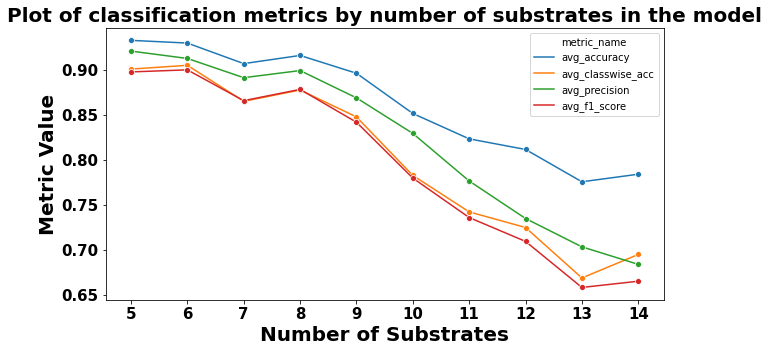

In [17]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [25]:
overall_catch.head()

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,5,countvectorizer,0.878788,0.839896,0.057168,0.088941,0.849349,0.839896,0.827340
1,5,doc2vec_dbow,0.743737,0.637000,0.062431,0.084478,0.678569,0.637000,0.642064
2,5,doc2vec_dm,0.932424,0.900571,0.014393,0.018879,0.920515,0.900571,0.897437
3,5,word2vec_cbow,0.919091,0.888286,0.029900,0.046169,0.880524,0.888286,0.878208
4,5,word2vec_sg,0.927980,0.894000,0.016676,0.025216,0.901444,0.894000,0.894218


In [38]:
# plt.figure(figsize = (20,10))
# sns.lineplot(data=overall_catch, x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,15), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

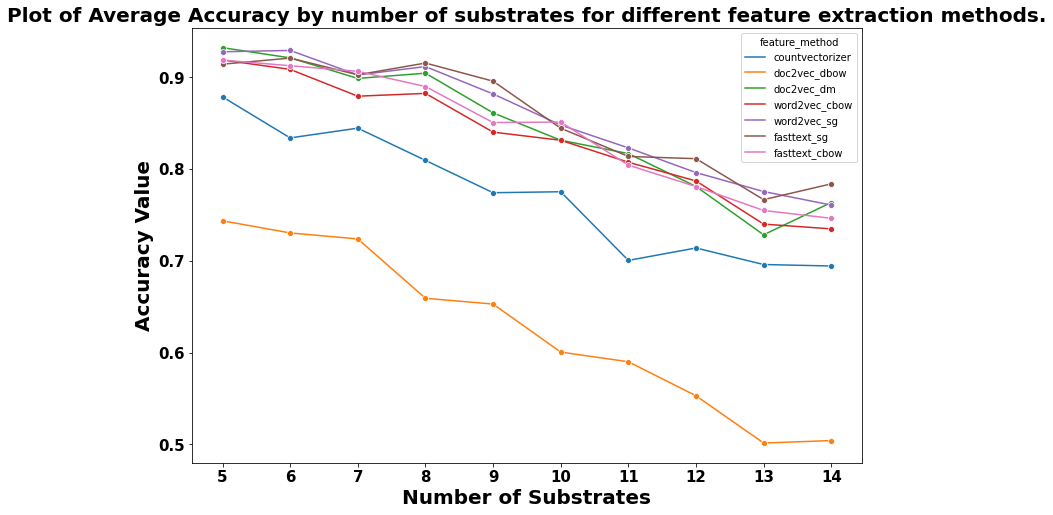

In [49]:
plt.figure(figsize = (12,8))
# filter_condn = [ "countvectorizer"]
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()